Learn the inter-grid kernels for homogeneous problems, RHS f = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math

from FEANet.mesh import MeshCircInterface
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 1] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshCircInterface(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [19]:
class TwoGrid(nn.Module):
    '''Define the two-grid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(TwoGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = 2 # two-grid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.zeros((n+1, n+1), dtype=np.float32)
        self.f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest rhs with the original rhs

        # Kernels for inter-grid communication 
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0
        self.conv.weight = nn.Parameter(restriction_kernel.reshape(1,1,3,3))
        self.conv.requires_grad_(False)

        self.deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        interpolation_kernel = torch.asarray([[1, 2, 1],
                                              [2, 4, 2],
                                              [1, 2, 1]], dtype=torch.float32) / 4.0
        interpolation_kernel = interpolation_kernel #+ torch.randn((3,3))
        self.deconv.weight = nn.Parameter(interpolation_kernel.reshape(1,1,3,3))
        self.deconv.requires_grad_(True)

        self.w = torch.asarray([4.,1.], dtype=torch.float32)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform full weighting operation to down sample to next level
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform linear interpolation and upsample to previous level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, u_list, m, m0):
        "Compute the convergence factor after m iterations"
        return torch.pow(torch.sqrt(torch.sum((self.f - self.grids[0].Knet(u_list[1])) ** 2))/torch.sqrt(torch.sum((self.f - self.grids[0].Knet(u_list[0])) ** 2)).item(), 1.0/(m-m0+1))

    def forward(self, x):
        v1, v2, v3 = [1, 20, 1] # number of relaxations
        xF = self.grids[0].Relax(x, self.f, v1)
        rF = self.f-self.grids[0].Knet(xF) # residual on fine grid
        rC = self.w[0]*self.Restrict(rF)
        xC = torch.zeros((1,1,int(self.n/2)+1,int(self.n/2)+1), dtype=torch.float32, requires_grad=False)
        eC = self.grids[1].Relax(xC, rC, v2) # solve for the coarse-grid error
        error_delta = self.w[1]*self.Interpolate(eC)
        xF = xF + error_delta
        x = self.grids[0].Relax(xF, self.f, v3)
        return x


In [20]:
n = 2**4
model = TwoGrid(n)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam([model.w], lr=1e-3)
model.deconv.weight

Parameter containing:
tensor([[[[0.2500, 0.5000, 0.2500],
          [0.5000, 1.0000, 0.5000],
          [0.2500, 0.5000, 0.2500]]]], requires_grad=True)

In [10]:
EPS = 5e-5
n_twogrid = 0
u = torch.randn((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
while (abs(res) > EPS):
    u = model(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "two-grid iterations ")

0 7.80534553527832
1 2.2929725646972656
2 0.7793200612068176
3 0.2931893765926361
4 0.12722310423851013
5 0.056592416018247604
6 0.027315683662891388
7 0.01261387299746275
8 0.005563561804592609
9 0.0025712396018207073
10 0.001053384505212307
11 0.0004290244251023978
12 0.00018415811064187437
13 7.431727863149717e-05
14 3.299598392914049e-05
Solution converges after 15 two-grid iterations 


In [11]:
m_iter = 10
m_0 = 5
num_epoch = 1000
q_list = []
for epoch in range(num_epoch):
    u = torch.rand((1,1,n-1,n-1))
    u = F.pad(u,(1,1,1,1),"constant",0)
    u_list = []
    for i in range(m_iter-1):
        u = model(u).detach()
        if(i == m_0-1):
            u_list.append(u)

    u = model(u)
    u_list.append(u)

    # compute convergence factor
    q = model.qm(u_list, m_iter, m_0)
    optimizer.zero_grad()
    q.backward()
    optimizer.step()
    q_list.append(q.item())
    print(epoch, q)

print("\nNew value:")
model.deconv.weight

0 tensor(0.5308, grad_fn=<PowBackward0>)
1 tensor(0.4913, grad_fn=<PowBackward0>)
2 tensor(0.5237, grad_fn=<PowBackward0>)
3 tensor(0.5318, grad_fn=<PowBackward0>)
4 tensor(0.5222, grad_fn=<PowBackward0>)
5 tensor(0.5163, grad_fn=<PowBackward0>)
6 tensor(0.5230, grad_fn=<PowBackward0>)
7 tensor(0.5085, grad_fn=<PowBackward0>)
8 tensor(0.5146, grad_fn=<PowBackward0>)
9 tensor(0.4997, grad_fn=<PowBackward0>)
10 tensor(0.4905, grad_fn=<PowBackward0>)
11 tensor(0.4875, grad_fn=<PowBackward0>)
12 tensor(0.4703, grad_fn=<PowBackward0>)
13 tensor(0.5203, grad_fn=<PowBackward0>)
14 tensor(0.5263, grad_fn=<PowBackward0>)
15 tensor(0.5013, grad_fn=<PowBackward0>)
16 tensor(0.4952, grad_fn=<PowBackward0>)
17 tensor(0.5155, grad_fn=<PowBackward0>)
18 tensor(0.5332, grad_fn=<PowBackward0>)
19 tensor(0.4933, grad_fn=<PowBackward0>)
20 tensor(0.5376, grad_fn=<PowBackward0>)
21 tensor(0.5070, grad_fn=<PowBackward0>)
22 tensor(0.5202, grad_fn=<PowBackward0>)
23 tensor(0.4880, grad_fn=<PowBackward0>)
24

Parameter containing:
tensor([[[[ 0.4521, -0.5410,  0.7452],
          [ 1.0507,  0.6964,  0.4280],
          [ 0.2049,  2.1179,  0.0873]]]], requires_grad=True)

Text(0.5, 0, 'epoch')

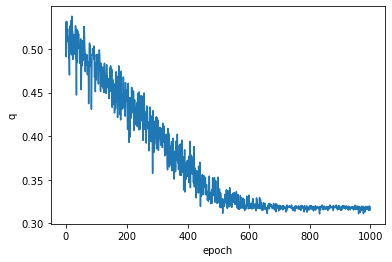

In [13]:
plt.plot(q_list)
plt.ylabel('q')
plt.xlabel('epoch')

In [14]:
EPS = 5e-5
n_twogrid = 0
u = torch.randn((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
while (abs(res) > EPS):
    u = model(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "two-grid iterations ")

0 5.688719272613525
1 1.0027834177017212
2 0.21423260867595673
3 0.04736809805035591
4 0.010527842678129673
5 0.0024674900341778994
6 0.000570181175135076
7 0.00013933882291894406
8 3.437443228904158e-05
Solution converges after 9 two-grid iterations 


In [21]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        # Problem parameters
        C = 0.0
        k = 1
        l = 2

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w.detach()
        self.restrict_kernel = inter_model.conv.weight.detach()
        self.interpolate_kernel = inter_model.deconv.weight.detach()
        
        u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)  # exact solution
        self.u_exact = torch.from_numpy(u_exact.reshape(1,1,n+1, n+1))

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = C*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        #f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        #v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        return v

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.w[1]*self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.randn((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

9.125604848942753 12.544121742248535
4.211354621034119 2.1144683361053467
3.5792157184126303 0.437865287065506
3.349660964397892 0.09658709913492203
3.2279068720139037 0.021953867748379707
3.1495714945424966 0.005083404015749693
3.0940624305518116 0.0011922799749299884
3.0525030224061465 0.00028231230680830777
3.0202235123861714 6.734273483743891e-05
2.994438848410509 1.6160376617335714e-05
Solution converges after 10 V-cycle iterations with relative error of 2.994438848410509


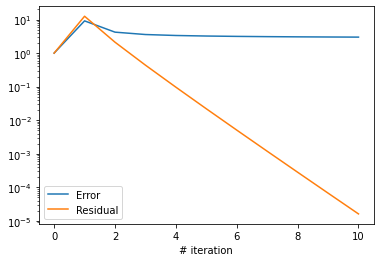

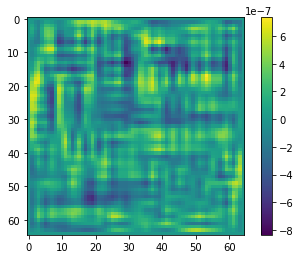

In [22]:
# Multigrid implementation
n = 2**6
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())